In [1]:
#
# Try to fit the magnetic data
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

<hr>
Modified  By    Reason <br>
07-Jan-22 CBL   Original <br>
08-Jan-22 CBL.  Added in optimization routines to find the center/radius of the circle and tilt. <br>
<hr>

In [2]:
def FindCenter(X0):
    # X0 the surmized center in (X0,Y0,Z0,R)
    # this relies on Mx,My and Mz to be global variables. 
    # we want this value to be zero.
    val= np.power(Mx-X0[0],2)+np.power(My-X0[1],2)+np.power(Mz-X0[2],2)-np.power(X0[3],2)
    # normalize val
    val = val/Mx.size
    rc = abs(val.sum())
    #print("result = ", rc)
    return rc
def FindPhi(Phi):
    # Input Phi in radians
    # ideally all X-Y points should be in a plane right now Mx,My,Mz appear to have at minimum a 
    # rotation around X or Y. This may be manifest in a Rx and Rz. How do we formulate the cost function?
    # While we have a theta (Z-rotation) and Phi (X rotation) lets see if we can tease the Phi rotation out. 
    Z_projection = M * math.cos(Phi) - mxy * math.sin(Phi)
    delta = Mz - Z_projection    # want this to be minimum
    rv = delta.sum()
    rv = abs(rv)
    return rv
def FindPhi1(Phi):
    delta = Mz - mxy*math.sin(Phi)
    return delta.var()

In [3]:
# Import the CSV using pandas
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
# In the file provided there are 1002 lines by 13 columns. 
# The data is organized by the way the names are assigned. 
#df = pd.read_csv("Mag2.CSV",names=['Index','Time','GX','GY','GZ','AX','AY','AZ','MX','MY','MZ','H','R','P'])
# Or I can format the file with Row 0 containing the names comma delimited and use a simpler read. 
# This data was taken using a 9DOF sensor from Sparkfun into an Arduino. 
# The sensor was slowly rotated several times. 
df = pd.read_csv("Mag2.CSV",dtype={'Index':np.int32,'Time':np.float64,
                                   'GX':np.float64,'GY':np.float64,'GZ':np.float64,
                                   'AZ':np.float64,'AY':np.float64,'AZ':np.float64,
                                   'MX':np.float64,'MY':np.float64,'MZ':np.float64,
                                   'H':np.float64,'R':np.float64,'P':np.float64})
ti = np.array(df['Index'])
Mx = np.array(df['MX'])     # Magnetic field X only
My = np.array(df['MY'])
Mz = np.array(df['MZ'])
mxy2 = np.power(Mx,2)+np.power(My,2)
mxy = np.sqrt(mxy2)
M  = np.sqrt(mxy2+np.power(Mz,2)) # the overall magnetic field scaler, this is invariant.
#
Ax = np.array(df['AX'])     # Acceleration
Ay = np.array(df['AY'])
Az = np.array(df['AZ'])
Axy2 = np.power(Ax,2)+np.power(Ay,2)
A = np.sqrt(Axy2+np.power(Az,2))
# best guess on angle Phi, The real Az should be 1. Therefore Az measured = cos(Phi)
# remove all zeros in the array to prevent nans in the division. 
rat = Az[Az!=0]/A[A != 0]
PhiGuess = np.arccos(rat)
PhiGuess0 = PhiGuess.mean()
# Print out result in degrees. Seems like the sensor is tilted in Phi by this value. 
print('Guess on angular rotation on Z = ', np.rad2deg(PhiGuess0), ' Deg')

Guess on angular rotation on Z =  9.457563084798261  Deg


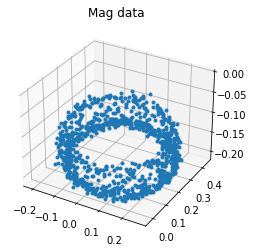

In [4]:
# Do a 3D plot of the data. 
# syntax for 3-D projection
plt.figure()
ax = plt.axes(projection ='3d')
#
# plotting
ax.plot3D(Mx,My,Mz,'.')
ax.set_title('Mag data')
plt.grid()
plt.show()

In [5]:
R = 0.2
X0 = [0,0,0, R]
val = FindCenter(X0)
val

0.0751179298528

In [6]:
# invoke a mimimization to find the center and radius
res = minimize(FindCenter, X0, method='nelder-mead', options={'xatol': 1e-4, 'disp': True})
res

Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 43
         Function evaluations: 83


 final_simplex: (array([[-0.00146719,  0.00058253, -0.00218607,  0.3380842 ],
       [-0.00146944,  0.00058276, -0.00218405,  0.33801484],
       [-0.00143327,  0.00058022, -0.00218712,  0.33800671],
       [-0.00146869,  0.00058182, -0.00218464,  0.33800577],
       [-0.00147484,  0.00058666, -0.00218733,  0.3381182 ]]), array([1.73463499e-05, 3.02531421e-05, 3.32328398e-05, 3.65382986e-05,
       4.19253590e-05]))
           fun: 1.7346349860713865e-05
       message: 'Optimization terminated successfully.'
          nfev: 83
           nit: 43
        status: 0
       success: True
             x: array([-0.00146719,  0.00058253, -0.00218607,  0.3380842 ])

<function matplotlib.pyplot.show>

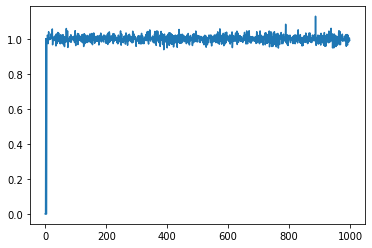

In [7]:
plt.plot(ti,Az)
plt.show

Variance before: 0.0011883539505404
Result: -0.1840614351549632  var: 0.0010616858780779245  change in var  0.0001266680724624754


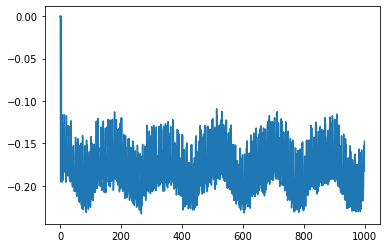

In [8]:
# This should be flat. Our guess for the offset in Phi
var0 = Mz.var()
print('Variance before:', var0)
delta = Mz - mxy * math.sin(0.09159302)
var1 = delta.var()
print('Result:',delta.mean(),' var:',var1, ' change in var ', var0-var1)
#plt.plot(ti,Mz-Mz.mean())
plt.plot(ti,delta)
plt.show()

In [9]:
# invoke a mimimization to find Phi angle from magnetic data
Phi0 = PhiGuess0
#res = minimize(FindPhi, Phi0, method='nelder-mead', options={'xatol': 1e-2, 'disp': True})
res = minimize(FindPhi1, Phi0, method='nelder-mead', options={'xatol': 1e-7, 'disp': True})
BestPhi = res.x
print("Result: ", np.rad2deg(BestPhi))
res

Optimization terminated successfully.
         Current function value: 0.001062
         Iterations: 23
         Function evaluations: 46
Result:  [5.24789332]


 final_simplex: (array([[0.09159302],
       [0.09159295]]), array([0.00106169, 0.00106169]))
           fun: 0.0010616858780779222
       message: 'Optimization terminated successfully.'
          nfev: 46
           nit: 23
        status: 0
       success: True
             x: array([0.09159302])

This result is marginally differnt than that found from the accleration data. 5.25 degrees vs 9.5 degrees.<br>
Putting this into the plot doesn't really change it as much as I would expect. <br>

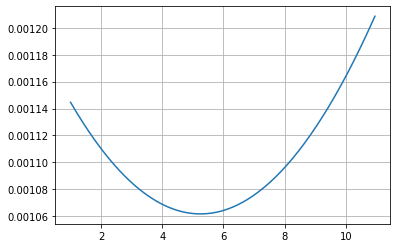

In [10]:
# Lets look at how much the variance changes as a function of the Phi angle (sensitivity study)
#
deg  = 1.0 # starting degrees
step = 0.050 # step degrees
var  = np.zeros(200)
x    = np.zeros(200)
for i in range(0,200):
    x[i] = deg
    theta = np.deg2rad(deg)
    delta = Mz - mxy * math.sin(theta)
    var[i] = delta.var()
    #print('deg:', deg)
    deg = deg + step
plt.plot(x,var)
plt.grid()
plt.show()

This plot here shows that the 5.25 value is more likely truth. Therefore there is a bias between the accelerometer 
and the magnetometer data. 

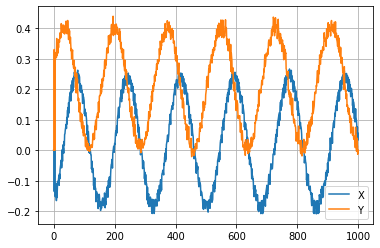

In [34]:
#
# Lets apply this this to obtain new XY data. 
#
#mxyp = M * math.cos(BestPhi)
#plt.plot(ti,mxyp)
#plt.plot(ti,M)
#plt.plot(ti, Mx*math.cos(BestPhi))
#plt.plot(ti, My*math.cos(BestPhi))
plt.plot(ti, Mx, label='X')
plt.plot(ti, My, label='Y')
plt.grid()
plt.legend()
plt.show()
# projection of Mx and My onto the rotated axes need to know the theta offset as well. this assumes zero

In [31]:
# Look at the values
for i in range(168,172):
    print(i,' ',Mx[i],My[i])

168   -0.15148 0.29652
169   -0.1883 0.27384000000000003
170   -0.16856 0.26824000000000003
171   -0.17836 0.29666


In [32]:
print(np.rad2deg(math.atan2(0.27384000000000003,-0.1883)))

124.5134953926385


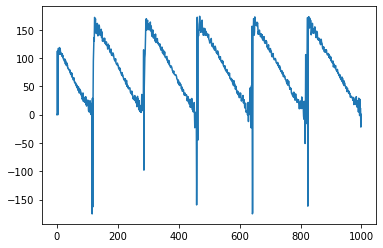

In [29]:
rawtheta = np.arctan2(My,Mx)
plt.plot(np.rad2deg(rawtheta))
plt.show()

Other than the disconinuity this isn't that bad. It just never goes negative. Atan2 should be -pi to pi. This is because y never goes negative. 

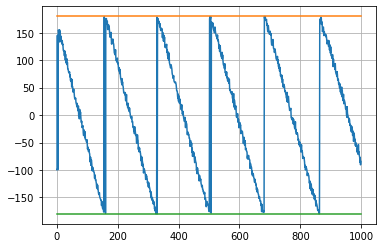

In [41]:
# try again to produce heading. 
# normalize the data that the two overlay each other and have equal excursions +/-
#htheta = np.arctan(y,x)
#plt.plot(np.rad2deg(htheta))
nx = np.array(Mx)
ny = np.array(My)
nx = nx - nx.mean()
ny = ny - ny.mean()
htheta = np.arctan2(ny,nx)
plt.plot(ti,np.rad2deg(htheta))
#plt.plot(ti,nx)
#plt.plot(ti,ny)
plt.plot([0,1000],[180,180])
plt.plot([0,1000],[-180,-180])
plt.grid()
plt.show()

And this looks roughly correct modulo the noise which a low pass filter will reject. The lines represent the upper and lower bounds. This does not mean that the values of the magnetic field are wrong, rather that they may have an offset due to some local field distortion. 

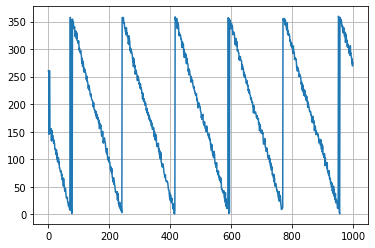

In [59]:
# finally turn this into a 0-360 plot
thetadeg = np.rad2deg(htheta)
index = np.where(thetadeg<0)
thetadeg[index] = thetadeg[index] + 360
#np.unwrap(thetadeg,math.pi/2)
plt.plot(ti,thetadeg)
plt.grid()
plt.show()

And this is good. 